In [1]:
import json
import os
from PIL import Image
from IPython.display import display
import glob
from tqdm import tqdm
import csv

In [2]:
dataset_path = "../dataset"
fontimage_path = os.path.join(dataset_path, "fontimage")
font_image_dir_path = os.path.join(dataset_path, "font_images")
taglabel_path = os.path.join(dataset_path, "taglabel")
fontset_path = os.path.join(dataset_path, "fontset")
train_font_path = os.path.join(fontset_path, "trainset")
val_font_path = os.path.join(fontset_path, "valset")
test_font_path = os.path.join(fontset_path, "testset")

In [3]:
readme = open(os.path.join(dataset_path, "readme.md"), "r").read()
print(readme)

The dataset corresponds to the paper "Large-scale Tag-based Font Retrieval with Generative Feature Learning" accepted by ICCV 2019.

The folder "fontimage" contains all the glyph images of 18,815 fonts.
The folder "taglabel" contains all the corresponding tag labels of the fonts.
The folder "fontset" contains the name of the training/validation/test fonts.
The folder "myfonts-testset" contains the single-tag and multi-tag queries we used in the experiment section.
The folder "AMT-testset" contains the AMT tagging set we used in the experiment section.
The folder "testfontvisual" contains the 5-letter images of each font in myfonts-testset for visualization.



If you make use of this dataset, please refer to the following paper:

Tianlang Chen, Zhaowen Wang, Ning Xu, Hailin Jin, and Jiebo Luo. "Large-scale Tag-based Font Retrieval with Generative Feature Learning", IEEE International Conference on Computer Vision(ICCV), 2019.



In [4]:
def extract_font_names(font_path):
  font_names = open(font_path, "r").read().split("\n")
  font_names = [
      font_name.replace(" ", "").replace("\n", "")
      for font_name in font_names
      if font_name != ""
  ]
  return font_names

def make_font_names_to_tags(font_names, base_tag_path):
  font_names_to_tags = {}
  tags_num = 0
  for font_name in font_names:
      tags = open(os.path.join(base_tag_path, font_name), "r").read().split(" ")
      tags = [tag.replace("\n", "") for tag in tags if tag != "" and tag!= "\n" and not (tag.startswith("%d")) and not ('%' in tag)]
      # tags = [tag.replace("-", " ") for tag in tags]
      if len(tags) == 0:
          continue
      font_names_to_tags[font_name] = tags
      tags_num += len(tags)
  print(f"average of tags_num: {tags_num / len(font_names_to_tags)}")
  return font_names_to_tags

In [5]:
train_font_names = extract_font_names(train_font_path)
val_font_names = extract_font_names(val_font_path)
test_font_names = extract_font_names(test_font_path)
print('train fonts num', len(train_font_names))
print('val fonts num', len(val_font_names))
print('test fonts num', len(test_font_names))

train fonts num 15061
val fonts num 1877
test fonts num 1877


In [6]:
len(train_font_names) + len(val_font_names) + len(test_font_names)

18815

In [7]:
train_font_names_to_tags = make_font_names_to_tags(train_font_names, taglabel_path)
val_font_names_to_tags = make_font_names_to_tags(val_font_names, taglabel_path)
test_font_names_to_tags = make_font_names_to_tags(test_font_names, taglabel_path)
# save font_names_to_tags as json
with open(os.path.join(dataset_path, 'font_names_to_tags.json'), 'w') as f:
    json.dump({'train': train_font_names_to_tags, 'val': val_font_names_to_tags, 'test': test_font_names_to_tags}, f)

average of tags_num: 15.659409643381862
average of tags_num: 15.112955032119915
average of tags_num: 15.795819935691318


In [8]:
tags = set()
for tmp_tags in train_font_names_to_tags.values():
    for tag in tmp_tags:
        tags.add(tag)
for tmp_tags in val_font_names_to_tags.values():
    for tag in tmp_tags:
        tags.add(tag)
for tmp_tags in test_font_names_to_tags.values():
    for tag in tmp_tags:
        tags.add(tag)
print(len(tags))

1820


In [35]:
print(tags)

{'easy to read', 'ussr', 'swirly', 'vernacular', 'fav', 'blob', 'element', 'calendar', 'luxury', 'personality', 'science fiction', 'forest', 'booklet', 'technological', 'delicious', 'rap', 'curly', 'tight', 'weather', 'theater', 'draw', 'calt', 'carnival', 'snowflake', 'background', 'typewriter', 'harmony', 'urban', 'spurless', 'antiqua', 'surfer', 'promotion', 'engineer', 'e book', 'subtle', 'persian font', 'web design', 'scifi', 'glamour', 'hip', 'strip', 'detroit serif', 'x height', 'reclame', '1930s', 'teenage', 'vital', 'connected script', 'm formula', 'grand display', 'expand', 'envelope', 'barcelona', 'baseball script', 'west', 'futurism', 'loop', 'instagram', 'ship', 'brushy', 'euro', 'machine', 'birthday', 'inky', 'city', 'old style figures', 'branding font', 'ornamental', 'backslant', 'cocktail', 'uppercase', 'monospaced', 'japanese', 'document', 'fax', 'technology', 'blot', 'rock', 'clarendon', 'grunge', 'apps', 'tuscan', 'ornament', 'strong', 'swirl', 'christianity', 'linea

# Prepare Image

In [8]:
def character_image_path(character, base_path):
  # if character is capital letter
  if character.isupper():
    postfix = f'{character}{character}'
  else:
    postfix = f'{character}'
  return f'{base_path}{postfix}.png'

In [9]:
def create_image(font_name, text, font_image_dir_path=fontimage_path, space_width=50):
  base_path = os.path.join(font_image_dir_path, f'{font_name}_')
  max_width = 0
  max_height = 0
  tmp_width = 0
  for character in text:
    if character == ' ':
      tmp_width += space_width
      continue
    if character == '\n':
      if tmp_width > max_width:
        max_width = tmp_width
      tmp_width = 0
      continue
    image_path = character_image_path(character, base_path)
    image = Image.open(image_path)
    width, height = image.size
    tmp_width += width
    if height > max_height:
      max_height = height

  line_num = text.count('\n') + 1
  #canvas = Image.new('RGB', (max_width, max_height * line_num), (255, 255, 255))
  canvas = Image.new('RGB', (max_height * 8, max_height * line_num), (255, 255, 255))
  tmp_height = 0
  tmp_width = 0
  for character in text:
    if character == ' ':
      tmp_width += space_width
      continue
    if character == '\n':
      tmp_height += max_height
      tmp_width = 0
      continue
    image_path = character_image_path(character, base_path)
    image = Image.open(image_path)
    width, _ = image.size
    canvas.paste(image, (tmp_width, tmp_height))
    tmp_width += max_height
  return canvas

In [13]:
text = "The quick\nbrown fox\njumps over\nthe lazy dog"
for i in tqdm(range(0, len(test_font_names))):
  font_name = test_font_names[i]
  image = create_image(font_name, text, fontimage_path, 0)
  width, height = image.size
  resized_image = image.resize((int(width / 4), int(height / 4)))
  resized_image.save(os.path.join(font_image_dir_path, font_name + '.png'))

100%|██████████| 1877/1877 [01:13<00:00, 25.61it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

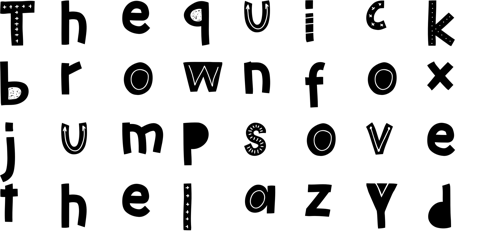

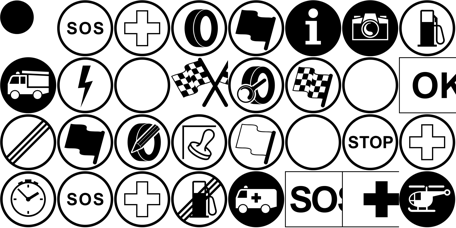

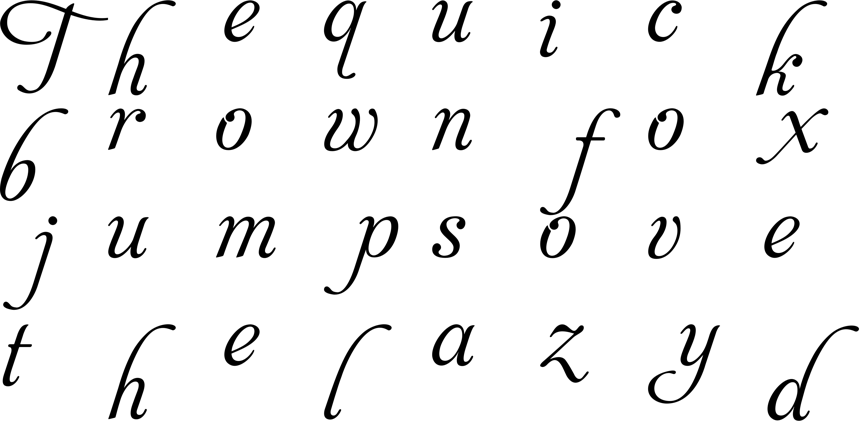

  8%|▊         | 3/40 [00:00<00:02, 18.15it/s]

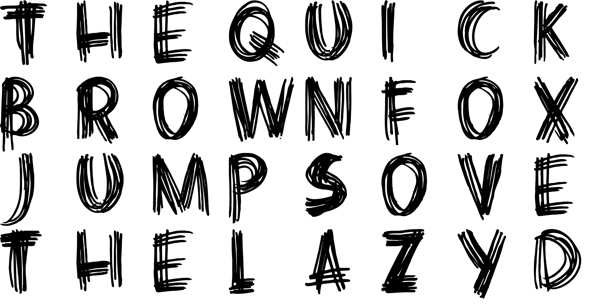

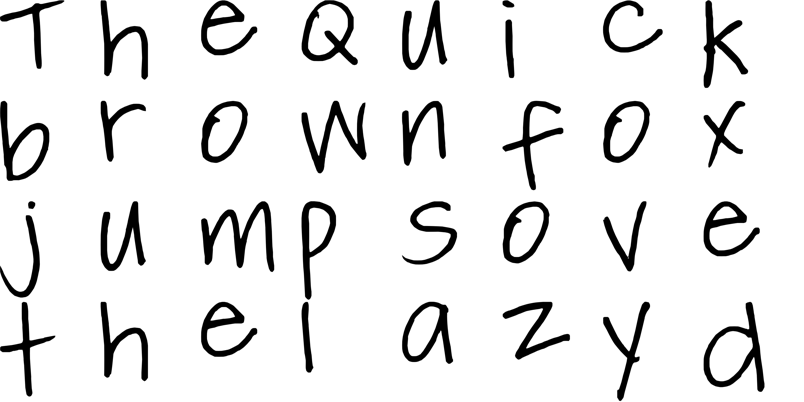

 12%|█▎        | 5/40 [00:00<00:02, 15.80it/s]

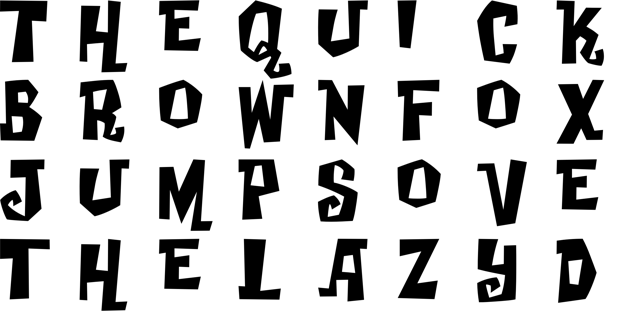

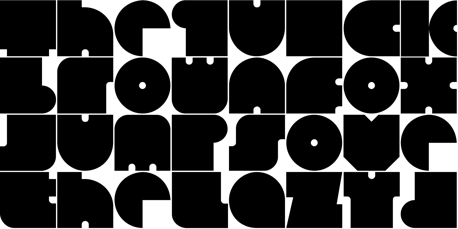

 18%|█▊        | 7/40 [00:00<00:01, 17.24it/s]

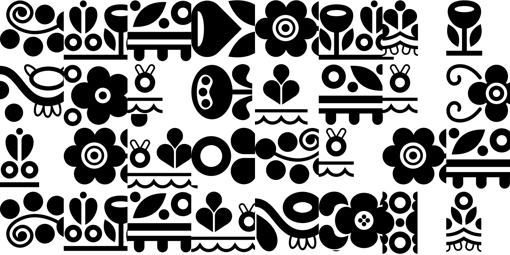

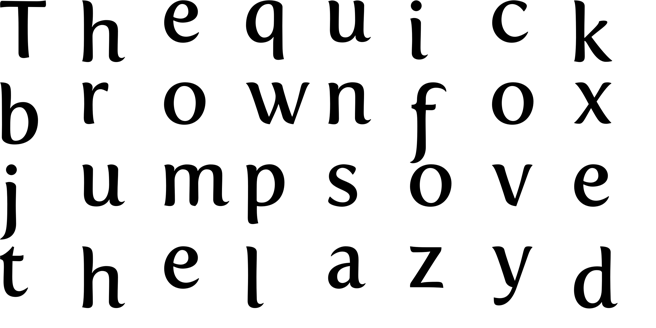

 22%|██▎       | 9/40 [00:00<00:01, 18.00it/s]

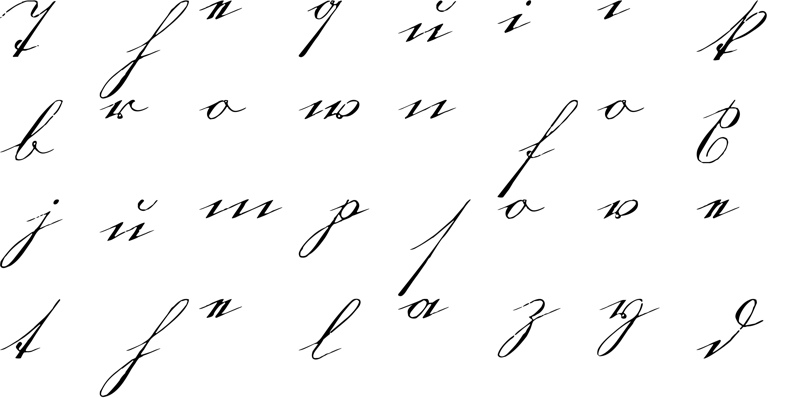

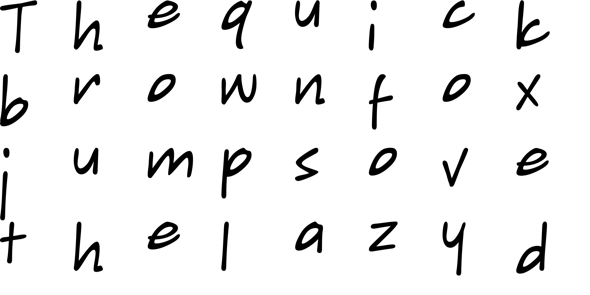

 28%|██▊       | 11/40 [00:00<00:01, 17.63it/s]

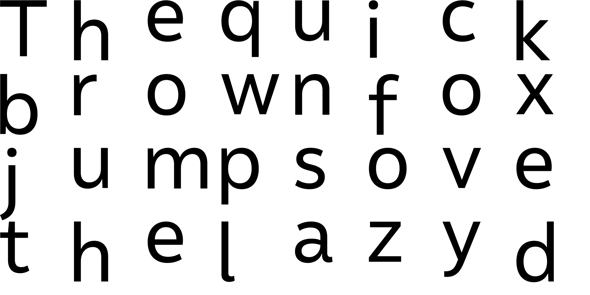

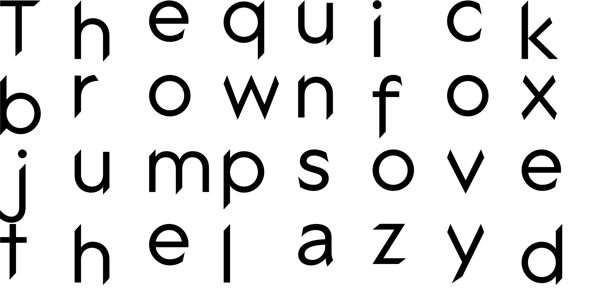

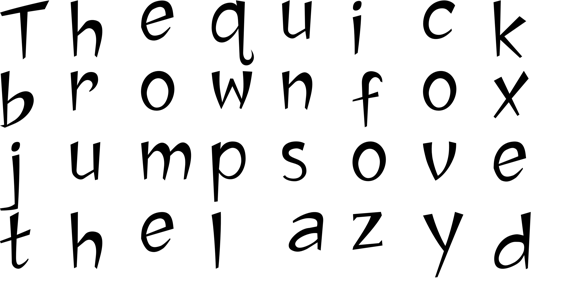

 35%|███▌      | 14/40 [00:00<00:01, 19.35it/s]

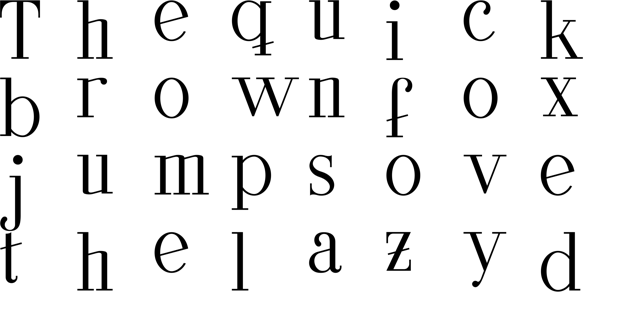

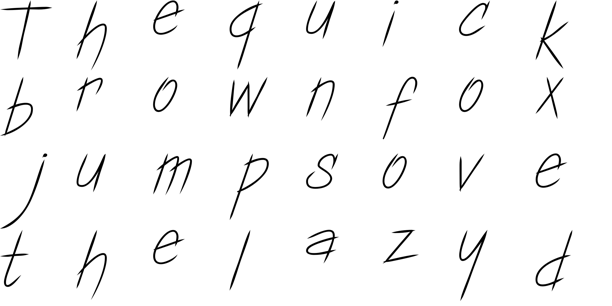

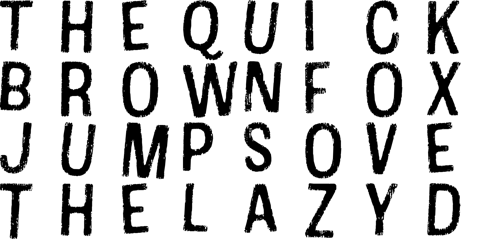

 42%|████▎     | 17/40 [00:00<00:01, 20.34it/s]

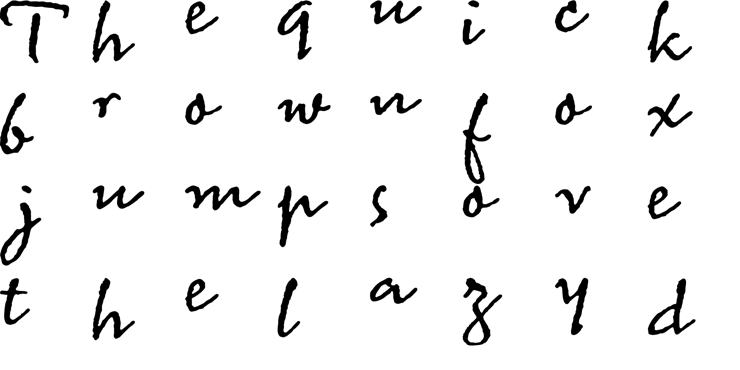

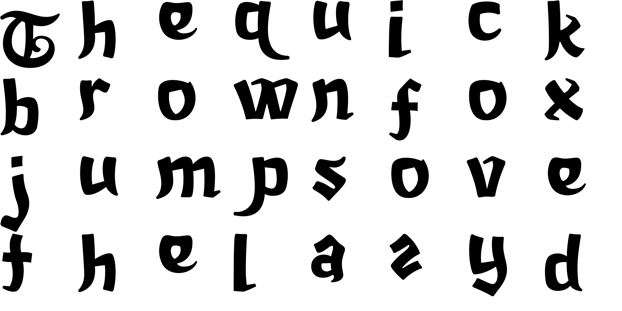

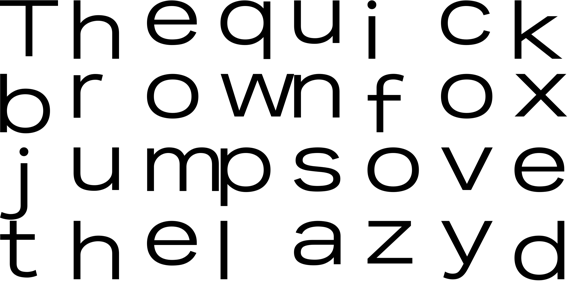

 50%|█████     | 20/40 [00:01<00:00, 20.91it/s]

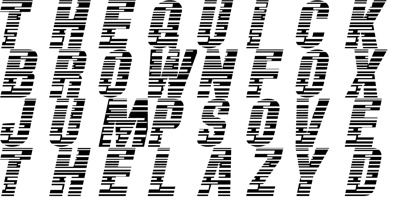

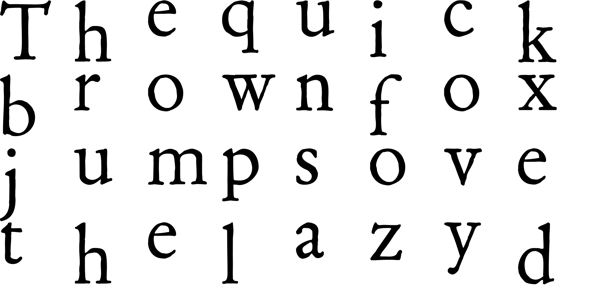

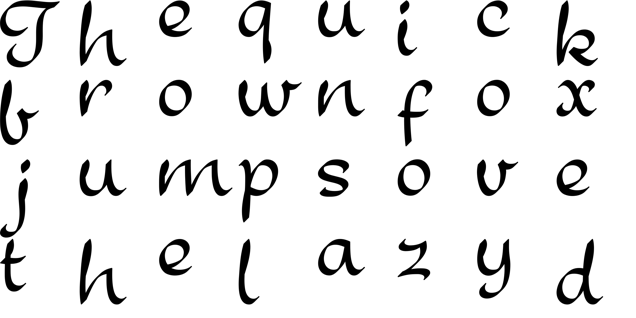

 57%|█████▊    | 23/40 [00:01<00:00, 21.88it/s]

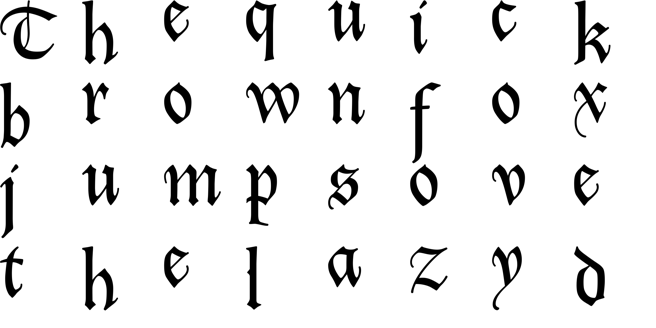

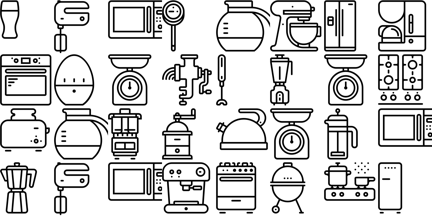

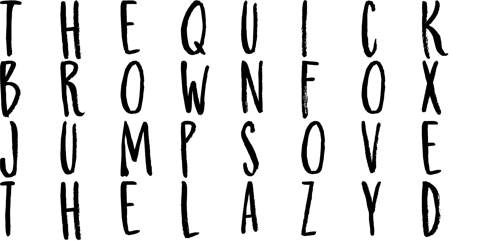

 65%|██████▌   | 26/40 [00:01<00:00, 22.43it/s]

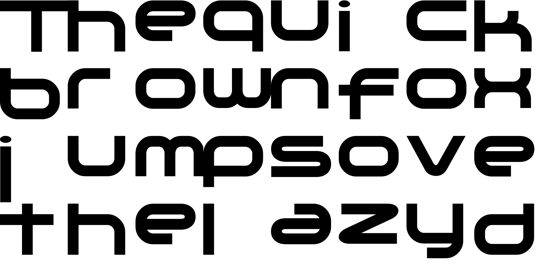

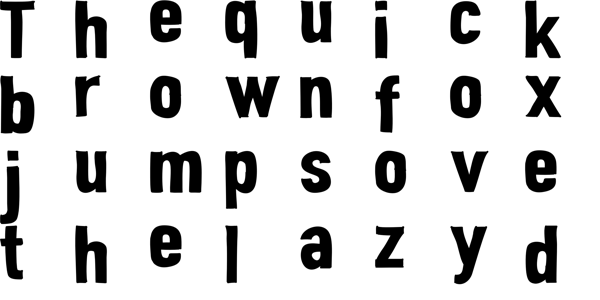

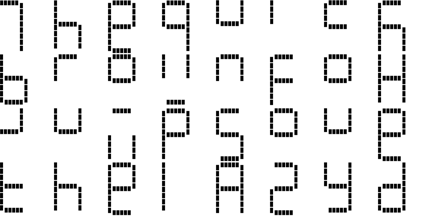

 72%|███████▎  | 29/40 [00:01<00:00, 23.17it/s]

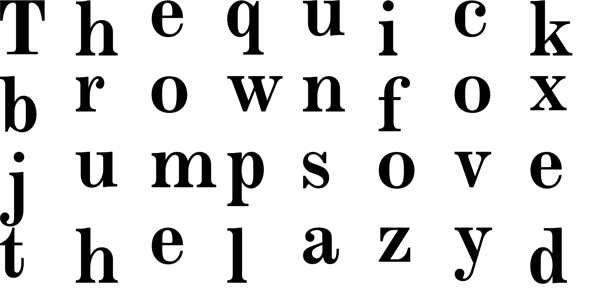

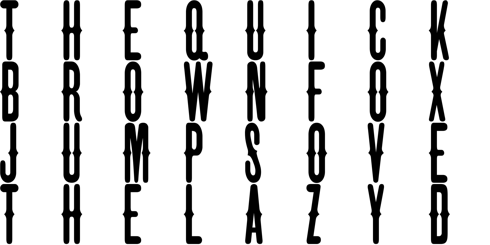

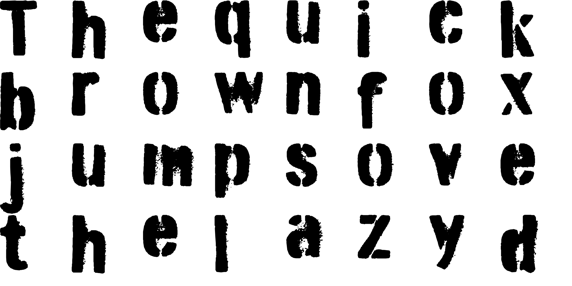

 80%|████████  | 32/40 [00:01<00:00, 23.29it/s]

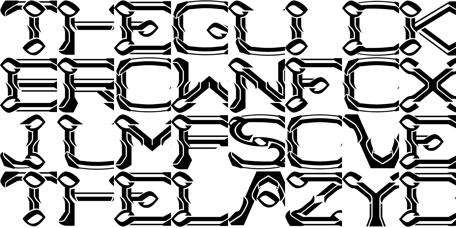

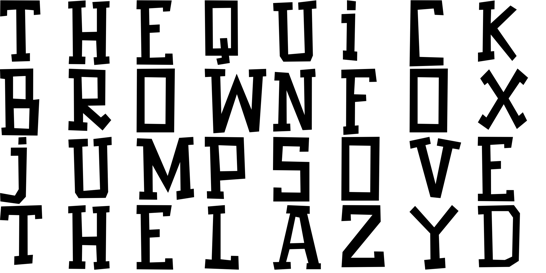

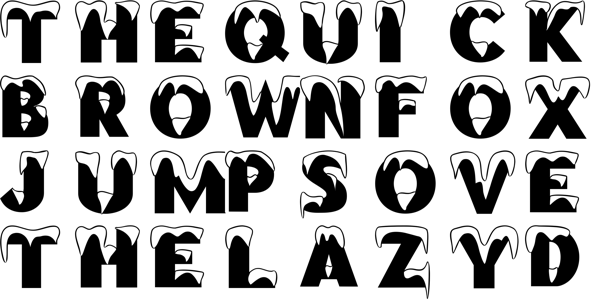

 88%|████████▊ | 35/40 [00:01<00:00, 23.02it/s]

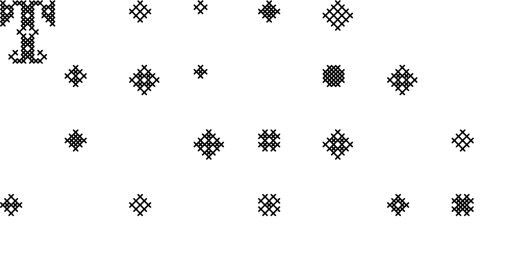

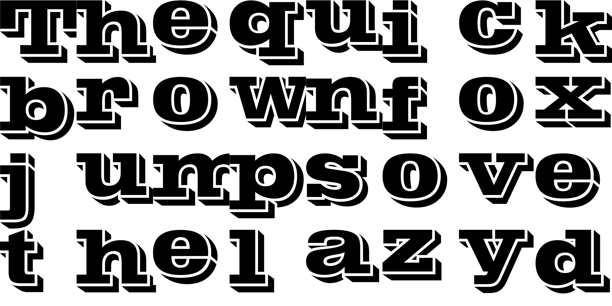

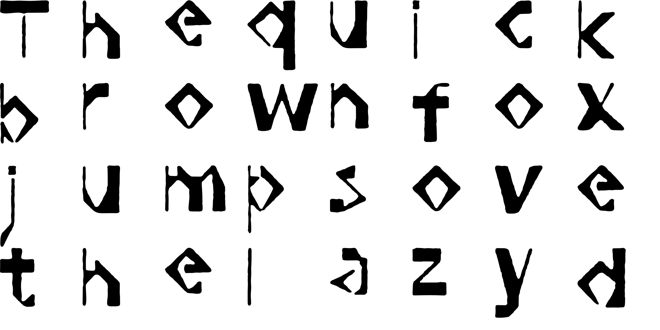

 95%|█████████▌| 38/40 [00:01<00:00, 23.65it/s]

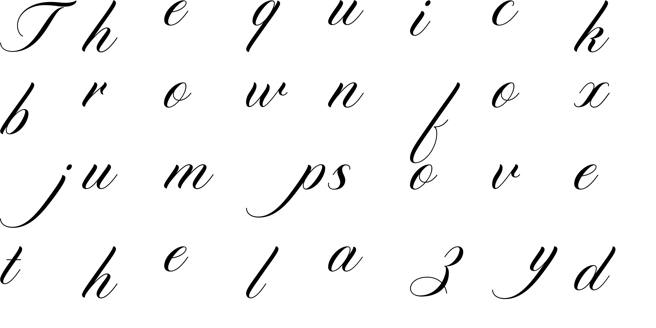

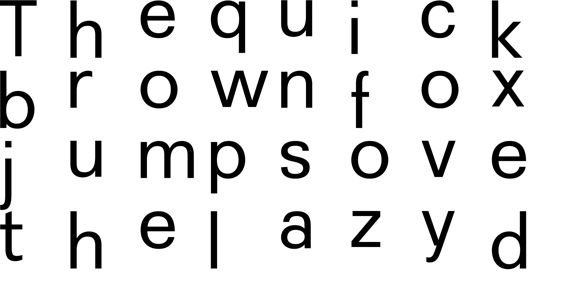

100%|██████████| 40/40 [00:01<00:00, 21.30it/s]


In [14]:
text = "The quick\nbrown fox\njumps over\nthe lazy dog"
for i in tqdm(range(10, 50)):
  font_name = test_font_names[i]
  image = create_image(font_name, text, fontimage_path, 0)
  width, height = image.size
  resized_image = image.resize((int(width / 4), int(height / 4)))
  display(resized_image)

# See AMT test dataset

In [38]:
AMT_testset_path = '../dataset/AMT-testset/data.csv'

In [41]:
with open(AMT_testset_path, 'r') as f:
  reader = csv.reader(f)
  testdata = [row for row in reader][1:]

In [43]:
testdata = [[data[0], data[1], data[2], data[3], int(data[4])] for data in testdata]
testdata

[['vintage', 'kinver', 'peperoncino-vintage', 'rephone', 0],
 ['vintage', 'chase', 'journey', 'pass-the-port', 0],
 ['vintage', 'archive-garamond', 'gradl-zierschriften', 'roves', 1],
 ['display', 'luminum', 'nouvelle-vague', 'soft-rock', 0],
 ['heavy', 'assembler', 'nantua', 'sahara-bodoni', 0],
 ['friendly', 'agatha', 'conga-brava-mm', 'pluto-sans', 1],
 ['heavy', 'cooper-black-sh', 'mamontov', 'meal-ticket', 0],
 ['heavy', 'cooper-black-sb', 'core-sans-m', 'tutti-paffuti-nf', 0],
 ['heavy', 'merina', 'soft-rock', 'wild1-nobody', 0],
 ['heavy', 'bb-book-contrasted', 'mr-dodo', 'wrought', 0],
 ['retro', 'catsy', 'mousse-script', 'rm-true-to-type', 2],
 ['brush', 'buffalo-joe', 'ht-cafe', 'lamiar', 1],
 ['friendly', 'bakerie', 'De-La-Croix', 'mixed-tape-rough', 0],
 ['brush', 'Sovetryne', 'sprig', 'xxii-awesomescript', 2],
 ['brush', 'mozzart-sketch', 'rifleman', 'santoro-script', 2],
 ['display', 'draft-beer', 'printing-press-cuts', 'stendo', 2],
 ['brush', 'linger-on', 'singlesville-

# See MyFont test dataset

In [8]:
MyFont_testset_path = '../dataset/myfonts-testset'
MyFont_testset_single_tag_path = '../dataset/myfonts-testset/singletag-test'

In [10]:
with open(MyFont_testset_single_tag_path, 'r') as f:
  data = f.readlines()